In [6]:
# import libraries needed
import time
import networkx as nx
from sortedcontainers import SortedList, SortedSet, SortedDict
import random
import numpy as np
import math
from itertools import chain, combinations
from networkx.generators.random_graphs import erdos_renyi_graph, fast_gnp_random_graph
from networkx.algorithms.matching import max_weight_matching
from subprocess import check_output
from gurobipy.gurobipy import Model, quicksum, GRB
import matplotlib.pylab as plt


In [7]:
# Create new edge and set edge weight and cost
def setEdgeData(G, edge, weight, cost):
    G.add_edge(edge[0], edge[1])
    G[edge[0]][edge[1]]['weight'] = weight
    G[edge[0]][edge[1]]['cost'] = cost

def getEdgeCost(G, edge):
    return G[edge[0]][edge[1]]['cost']

def getEdgeWeight(G, edge):
    return G[edge[0]][edge[1]]['weight']

def zerotruncatedPoisson(p):
    #source: https://web.archive.org/web/20180826164029/http://giocc.com/zero_truncated_poisson_sampling_algorithm.html
    k = 1
    t = math.e**(-p) / (1 - math.e**(-p)) * p
    s = t
    u = random.random()
    while s < u:
        k += 1
        t *= p / k
        s += t
    return k

def isMatching(edges):
    # Check if set of edges is matching
    seen = []
    for e in edges:
        if e[0] in seen:
            return False
        seen.append(e[0])
        if e[1] in seen:
            return False
        seen.append(e[1])
    return True

def powerset(iterable, maxSize):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(maxSize+1))
def powersetAll(iterable):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))



def generateRandomGraph(n, p, Ew, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ew: zero truncated poisson weight parameter
    Ec: poisson cost parameter
    """
    graph = erdos_renyi_graph(n,p)
    for edge in graph.edges:
        weight = 0
        cost = 0
        weight = zerotruncatedPoisson(Ew)
        cost = np.random.poisson(Ec)
        setEdgeData(graph, edge, weight, cost)
    return graph
    

def computeCost(g, matching):
    # compute cost of matching
    return sum(getEdgeCost(g, e) for e in matching)
def computeWeight(g, matching):
    # compute weight of matching
    return sum(getEdgeWeight(g, e) for e in matching)
def budgetedMatchingProblemBruteforce(g, B):
    # solve BMP by bruteforce
    maximum = 0
    cost = 0
    matching = None
    for e in powerset(g.edges, len(g.nodes)//2):
        if isMatching(e):
            c = computeCost(g, e)
            m = computeWeight(g, e)
            if c <= B and m > maximum:
                maximum = m
                matching = e
                cost = c
    return cost, maximum, matching

def generateRandomRestricted(n, p, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    The weights of all edges are 1
    The costs are following a poisson parameter
    Here the 'weight' variable of each edge denotes the edge cost not edge weight
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ec: poisson cost parameter
    """
    graph = fast_gnp_random_graph(n,p)
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = np.random.poisson(Ec) # Edge cost!
    return graph

def restrictedToGeneral(G):
    """
    Transform graph instance with weights 1
    to general instance of budgeted matching problem
    """
    graph = nx.Graph()
    for e in G.edges():
        setEdgeData(graph, e, 1, G[e[0]][e[1]]['weight'])
    return graph

In [8]:
def graphToAdjacency(G):
    """
    Returns adjacency list from graph
    """
    lines = []
    lines.append(str(len(G.nodes)))
    lines.append(str(len(G.edges)))
    for e in G.edges:
        e0 = e[0]
        e1 = e[1]
        lines.append(f"{e0} {e1} {G[e0][e1]['weight']}")
    return lines


def min_cost_matching(G):
    """
    Returns minimum cost perfect matching, if exists else false
    """
    adjacency = graphToAdjacency(G)
    f = open("input.txt", "w")
    for line in adjacency:
        f.write(line)
        f.write("\n")
    f.close()
    try:
        raw_data = check_output('MinimumCostMatching\example -f input.txt --minweight', shell=True).decode('utf-8').split(":")[-1].split("\r\n")
    except:
        return False
    return set(tuple(int(e) for e in x.split(" ")) for x in raw_data if x!="")

def min_cost_matching_size_k(G, k):
    """
    Compute minimum cost matching of size k
    """
    graph = transform_graph_min_size_k(G, k)
    matching = min_cost_matching(graph)
    if matching == False: return False
    nodesG = len(G.nodes)
    return set(x for x in matching if (x[0] < nodesG and x[1] < nodesG))

def maxweight_to_min_weight(G):
    """
    Transform a max weight problem to min weight problem
    while making sure all edge weights are non-negative
    """
    if len(G.edges) == 0:
        return G.copy()
    maxWeight = max(G[edge[0]][edge[1]]['weight'] for edge in G.edges)
    graph = G.copy()
    for edge in G.edges:
        graph[edge[0]][edge[1]]['weight'] = maxWeight - G[edge[0]][edge[1]]['weight']
    return graph

def transform_graph_min_size_k(G, k, weight="weight"):
    """
    Transforms max weight matching to max weight matching on k vertices
    """
    transG = nx.Graph()
    G_edges = G.edges(data=weight, default=1)
    edges = ((u, v, w) for u, v, w in G_edges)
    transG.add_weighted_edges_from(edges, weight=weight)
    old_nodes = list(G.nodes).copy()
    for i in range(len(G.nodes), 2*len(G.nodes)-2*k):
        for j in old_nodes:
            transG.add_edge(j, i, weight=0)
    return transG

In [9]:
def solve_fcbmp(G, B):
    """
    Solve the budgeted amtching problem with fixed cost constraint in polynomial time
    """
    graph = maxweight_to_min_weight(G)
    maxWeight = 0
    budget = 0
    for i in range(1, min(B, len(G.nodes)//2) + 1):
        matching = min_cost_matching_size_k(graph, i)
        weight = 0
        if matching:
            weight = sum(G[edge[0]][edge[1]]['weight'] for edge in matching)
        if weight > maxWeight:
            maxWeight = weight
            budget = i
    return (maxWeight, budget)

In [10]:
G = generateRandomRestricted(100, 0.8, 1)

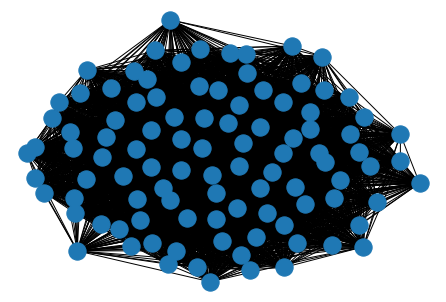

In [11]:
nx.draw(G)

In [12]:
solve_fcbmp(G, 12)

(58, 12)

In [13]:
# ============================================ GUROBI ====================================================
def restricted_graph_to_gurobi(graph, budget):
    # instance of BMP with fixed cost to gurobi instance
    model = Model("Budgeted Matching Restricted")
    x = {}
    edges = list(graph.edges)
    nodes = list(graph.nodes)
    for e in edges:
        x[e] = model.addVar(vtype=GRB.INTEGER, name=f'edge[{e}]', lb = 0, ub=1)
    model.addConstrs(
        (quicksum(x[e] for e in edges if v in e) <= 1 for v in nodes),
        name='Satisfy Matching'
    )
    model.addConstr(
        quicksum(x[e] for e in edges) <= budget,
        name='Satisfy Budget'
    )
    model.setObjective(
        quicksum(x[e] * getEdgeWeight(graph, e) for e in edges),
        sense=GRB.MAXIMIZE
    )
    return model

In [14]:
restricted_graph_to_gurobi(G, 12).optimize()

Using license file c:\gurobi912\gurobi.lic
Set parameter TokenServer to value TUELICENSE4.campus.tue.nl
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 3952 columns and 11856 nonzeros
Model fingerprint: 0x1777822c
Variable types: 0 continuous, 3952 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 1467 columns
Presolve time: 0.01s
Presolved: 101 rows, 2485 columns, 7455 nonzeros
Variable types: 0 continuous, 2485 integer (2485 binary)

Root relaxation: objective 5.800000e+01, 102 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0     

In [15]:
'''
Test of budgeted matching with fixed cost on dense graphs
Results get saved in dict times_brute_dense and times_gurobi_dense
'''
# Dense Graphs
times_brute_dense = {}
times_gurobi_dense = {}
for n in range(0, 201, 10):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 0.8, 10)
        gurobi = restricted_graph_to_gurobi(g, n//4)
        start = time.time()
        solve_fcbmp(g, n//4)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute_dense[n] = running_time_bruteforce / 5
    times_gurobi_dense[n] = running_time_gurobi / 5

iterationnumber 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Model fingerprint: 0x0268838a
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Model fingerprint: 0x0268838a
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00,

Model fingerprint: 0x5103d78f
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 15.0000000
Presolve time: 0.00s
Presolved: 11 rows, 35 columns, 105 nonzeros
Variable types: 0 continuous, 35 integer (35 binary)

Root relaxation: objective 3.000000e+01, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      30.0000000   30.00000  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 30 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
iterationnumber 20
Gurobi Optimizer versi

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 75.0000000
Presolve time: 0.00s
Presolved: 31 rows, 352 columns, 1056 nonzeros
Variable types: 0 continuous, 352 integer (352 binary)

Root relaxation: objective 1.290000e+02, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     129.0000000  129.00000  0.00%     -    0s

Explored 0 nodes (20 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 129 75 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.290000000000e+02, best bound 1.290000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using 

  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 102.0000000
Presolve time: 0.00s
Presolved: 41 rows, 622 columns, 1866 nonzeros
Variable types: 0 continuous, 622 integer (622 binary)

Root relaxation: objective 1.900000e+02, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     190.0000000  190.00000  0.00%     -    0s

Explored 0 nodes (34 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 190 102 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+02, best bound 1.900000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41 rows, 620 colu

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 155.0000000
Presolve time: 0.01s
Presolved: 61 rows, 1376 columns, 4128 nonzeros
Variable types: 0 continuous, 1376 integer (1376 binary)

Root relaxation: objective 2.810000e+02, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.0000000  281.00000  0.00%     -    0s

Explored 0 nodes (48 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 281 155 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.810000000000e+02, best bound 2.810000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 1406 columns and 4218 nonzeros
Model fi

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 164.0000000
Presolve time: 0.01s
Presolved: 71 rows, 1922 columns, 5766 nonzeros
Variable types: 0 continuous, 1922 integer (1922 binary)

Root relaxation: objective 3.250000e+02, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     325.0000000  325.00000  0.00%     -    0s

Explored 0 nodes (60 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 325 164 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.250000000000e+02, best bound 3.250000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 71 rows, 1927 columns and 5781 nonzeros
Model fi

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 200.0000000
Presolve time: 0.01s
Presolved: 81 rows, 2533 columns, 7599 nonzeros
Variable types: 0 continuous, 2533 integer (2533 binary)

Root relaxation: objective 3.860000e+02, 78 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     386.0000000  386.00000  0.00%     -    0s

Explored 0 nodes (78 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 386 200 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.860000000000e+02, best bound 3.860000000000e+02, gap 0.0000%
iterationnumber 90
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 91 rows, 3207 columns and 962

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 270.0000000
Presolve time: 0.01s
Presolved: 101 rows, 4020 columns, 12060 nonzeros
Variable types: 0 continuous, 4020 integer (4020 binary)

Root relaxation: objective 4.860000e+02, 112 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     486.0000000  486.00000  0.00%     -    0s

Explored 0 nodes (112 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 486 270 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.860000000000e+02, best bound 4.860000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 3951 columns and 11853 nonzeros
Mo

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 290.0000000
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 111 rows, 4824 columns, 14472 nonzeros
Variable types: 0 continuous, 4824 integer (4824 binary)

Root relaxation: objective 5.300000e+02, 97 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     530.0000000  530.00000  0.00%     -    0s

Explored 0 nodes (97 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 530 290 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.300000000000e+02, best bound 5.300000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 

Model fingerprint: 0x8928dabe
Variable types: 0 continuous, 6732 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 303.0000000
Presolve time: 0.02s
Presolved: 131 rows, 6732 columns, 20196 nonzeros
Variable types: 0 continuous, 6732 integer (6732 binary)

Root relaxation: objective 6.440000e+02, 132 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     644.0000000  644.00000  0.00%     -    0s

Explored 0 nodes (132 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 644 303 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.440000000000e+02, best bound 6.440000000000e+02, gap 0.0000%
Gurobi Optimizer versio

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 141 rows, 7825 columns and 23475 nonzeros
Model fingerprint: 0xabcc9239
Variable types: 0 continuous, 7825 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 376.0000000
Presolve time: 0.02s
Presolved: 141 rows, 7825 columns, 23475 nonzeros
Variable types: 0 continuous, 7825 integer (7825 binary)

Root relaxation: objective 6.920000e+02, 130 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     692.0000000  692.00000  0.00%     -    0s

Explored 0 nodes (130 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 692 376 

Opt

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 151 rows, 8937 columns and 26811 nonzeros
Model fingerprint: 0x9a1c9aa8
Variable types: 0 continuous, 8937 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 335.0000000
Presolve time: 0.02s
Presolved: 151 rows, 8937 columns, 26811 nonzeros
Variable types: 0 continuous, 8937 integer (8937 binary)

Root relaxation: objective 7.240000e+02, 168 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     724.0000000  724.00000  0.00%     -    0s

Explored 0 nodes (168 simplex iterations) in 0.06 seconds
Thread count was 12 (of 12


Solution count 2: 843 403 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.430000000000e+02, best bound 8.430000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 171 rows, 11520 columns and 34560 nonzeros
Model fingerprint: 0x94e9a26a
Variable types: 0 continuous, 11520 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 465.0000000
Presolve time: 0.03s
Presolved: 171 rows, 11520 columns, 34560 nonzeros
Variable types: 0 continuous, 11520 integer (11520 binary)

Root relaxation: objective 8.640000e+02, 182 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*   


Root relaxation: objective 9.180000e+02, 128 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     918.0000000  918.00000  0.00%     -    0s

Explored 0 nodes (128 simplex iterations) in 0.08 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 918 433 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.180000000000e+02, best bound 9.180000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 181 rows, 12821 columns and 38463 nonzeros
Model fingerprint: 0xa64d9447
Variable types: 0 continuous, 12821 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]


Found heuristic solution: objective 436.0000000
Presolve time: 0.04s
Presolved: 191 rows, 14359 columns, 43077 nonzeros
Variable types: 0 continuous, 14359 integer (14359 binary)

Root relaxation: objective 9.510000e+02, 239 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     951.0000000  951.00000  0.00%     -    0s

Explored 0 nodes (239 simplex iterations) in 0.09 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 951 436 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.510000000000e+02, best bound 9.510000000000e+02, gap 0.0000%
iterationnumber 200
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 201 rows, 15916 columns and 47748 nonzeros
Model fingerprint: 0xa7277528
Variable types: 

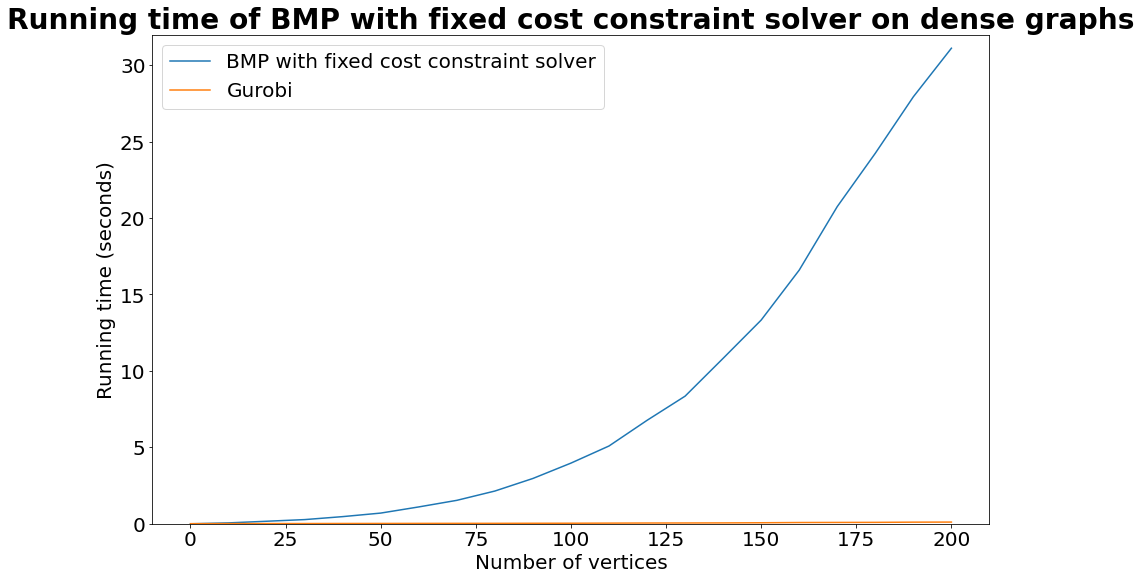

In [21]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute_dense.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi_dense.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['BMP with fixed cost constraint solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of BMP with fixed cost constraint solver on dense graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim([0,32])
plt.show()

In [18]:
'''
Test of budgeted matching with fixed cost on sparse graphs
Results get saved in dict times_brute and times_gurobi
'''
# Sparse Graphs
times_brute = {}
times_gurobi = {}
for n in range(10, 201, 10):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 2 / n, 10)
        gurobi = restricted_graph_to_gurobi(g, n//4)
        start = time.time()
        solve_fcbmp(g, n//4)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute[n] = running_time_bruteforce / 5
    times_gurobi[n] = running_time_gurobi / 5

iterationnumber 10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 15 columns and 45 nonzeros
Model fingerprint: 0xacf56901
Variable types: 0 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 22.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 11 rows, 12 columns, 36 nonzeros
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 3.200000e+01, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      32.0000000   32.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 23 columns and 69 nonzeros
Model fingerprint: 0x7645b1f2
Variable types: 0 continuous, 23 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve removed 12 rows and 9 columns
Presolve time: 0.00s
Presolved: 9 rows, 14 columns, 32 nonzeros
Found heuristic solution: objective 66.0000000
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective 6.800000e+01, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      68.0000000   68.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12


*    0     0               0     103.0000000  103.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 103 95 65 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.030000000000e+02, best bound 1.030000000000e+02, gap 0.0000%
iterationnumber 40
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41 rows, 46 columns and 138 nonzeros
Model fingerprint: 0x5d5600c6
Variable types: 0 continuous, 46 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 111.0000000
Presolve removed 18 rows and 15 columns
Presolve time: 0.00s
Presolved: 23 rows, 31 columns, 83 nonzeros
Variable types: 0 continuous, 31 integer (30 binary)

Root 

Presolve removed 42 rows and 19 columns
Presolve time: 0.00s
Presolved: 9 rows, 17 columns, 33 nonzeros
Found heuristic solution: objective 138.0000000
Variable types: 0 continuous, 17 integer (15 binary)

Root relaxation: objective 1.510000e+02, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     151.0000000  151.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 151 138 118 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.510000000000e+02, best bound 1.510000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 51 rows, 57 columns and 171 nonzeros
Model fingerprint: 0xe7c5d608
Variable types: 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 54 columns and 162 nonzeros
Model fingerprint: 0xa4d9188c
Variable types: 0 continuous, 54 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 144.0000000
Presolve removed 51 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 23 columns, 47 nonzeros
Found heuristic solution: objective 190.0000000
Variable types: 0 continuous, 23 integer (20 binary)

Root relaxation: objective 1.960000e+02, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     196.0000000  196.00000  0.00%     -    0s

Explored 0 node


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     244.0000000  244.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 244 218 162 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.440000000000e+02, best bound 2.440000000000e+02, gap 0.0000%
iterationnumber 80
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 81 rows, 79 columns and 237 nonzeros
Model fingerprint: 0x4746ee99
Variable types: 0 continuous, 79 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 201.0000000
Presolve re

Model fingerprint: 0xdb7124b3
Variable types: 0 continuous, 75 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 194.0000000
Presolve removed 68 rows and 35 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 91 nonzeros
Found heuristic solution: objective 252.0000000
Variable types: 0 continuous, 40 integer (35 binary)

Root relaxation: objective 2.840000e+02, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     284.0000000  284.00000  0.00%     -    0s

Explored 0 nodes (12 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 284 252 194 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.840000


*    0     0               0     338.0000000  338.00000  0.00%     -    0s

Explored 0 nodes (17 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 338 329 276 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.380000000000e+02, best bound 3.380000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 86 columns and 258 nonzeros
Model fingerprint: 0x4b52bf9a
Variable types: 0 continuous, 86 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 227.0000000
Presolve removed 68 rows and 31 columns
Presolve time: 0.00s
Presolved: 33 rows, 55 columns, 126 nonzeros
Found heuristic solution: objective 297.0000000
Variable types: 0 continu

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 255.0000000
Presolve removed 69 rows and 42 columns
Presolve time: 0.00s
Presolved: 42 rows, 64 columns, 160 nonzeros
Found heuristic solution: objective 326.0000000
Variable types: 0 continuous, 64 integer (58 binary)

Root relaxation: objective 3.560000e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     356.0000000  356.00000  0.00%     -    0s

Explored 0 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 356 326 255 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.560000000000e+02, best bound 3.560000000000e+02, gap 0.0000%
iterationnumber 120
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical 

Thread count was 12 (of 12 available processors)

Solution count 3: 403 380 328 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.030000000000e+02, best bound 4.030000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 131 rows, 128 columns and 384 nonzeros
Model fingerprint: 0x88009f3d
Variable types: 0 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 311.0000000
Presolve removed 101 rows and 79 columns
Presolve time: 0.00s
Presolved: 30 rows, 49 columns, 117 nonzeros
Found heuristic solution: objective 400.0000000
Variable types: 0 continuous, 49 integer (42 binary)

Root relaxation: objective 4.360000e+02, 8 iterations, 0.00 seconds

    Nodes    |    Current Node   

Presolve removed 91 rows and 62 columns
Presolve time: 0.00s
Presolved: 50 rows, 83 columns, 209 nonzeros
Found heuristic solution: objective 436.0000000
Variable types: 0 continuous, 83 integer (77 binary)

Root relaxation: objective 4.610000e+02, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     461.0000000  461.00000  0.00%     -    0s

Explored 0 nodes (28 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 461 436 347 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.610000000000e+02, best bound 4.610000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 141 rows, 153 columns and 459 nonzeros
Model fingerprint: 0xee56f3d9
Variable t

Best objective 5.010000000000e+02, best bound 5.010000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 151 rows, 123 columns and 369 nonzeros
Model fingerprint: 0xd13d5b28
Variable types: 0 continuous, 123 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 330.0000000
Presolve removed 116 rows and 63 columns
Presolve time: 0.00s
Presolved: 35 rows, 60 columns, 138 nonzeros
Found heuristic solution: objective 429.0000000
Variable types: 0 continuous, 60 integer (50 binary)

Root relaxation: objective 4.750000e+02, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

Found heuristic solution: objective 517.0000000
Variable types: 0 continuous, 126 integer (121 binary)

Root relaxation: objective 5.480000e+02, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     548.0000000  548.00000  0.00%     -    0s

Explored 0 nodes (40 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 548 517 416 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.480000000000e+02, best bound 5.480000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 171 rows, 176 columns and 528 nonzeros
Model fingerprint: 0xaad7d388
Variable types: 0 continuous, 176 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  O

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 181 rows, 198 columns and 594 nonzeros
Model fingerprint: 0x15cb5481
Variable types: 0 continuous, 198 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 432.0000000
Presolve removed 116 rows and 95 columns
Presolve time: 0.00s
Presolved: 65 rows, 103 columns, 260 nonzeros
Found heuristic solution: objective 574.0000000
Variable types: 0 continuous, 103 integer (93 binary)

Root relaxation: objective 6.140000e+02, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     614.0000000  614.00000  0.00%     -    0s

Explore


Root relaxation: objective 6.310000e+02, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     631.0000000  631.00000  0.00%     -    0s

Explored 0 nodes (30 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 631 584 469 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.310000000000e+02, best bound 6.310000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 191 rows, 183 columns and 549 nonzeros
Model fingerprint: 0x2d7bb2aa
Variable types: 0 continuous, 183 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Foun

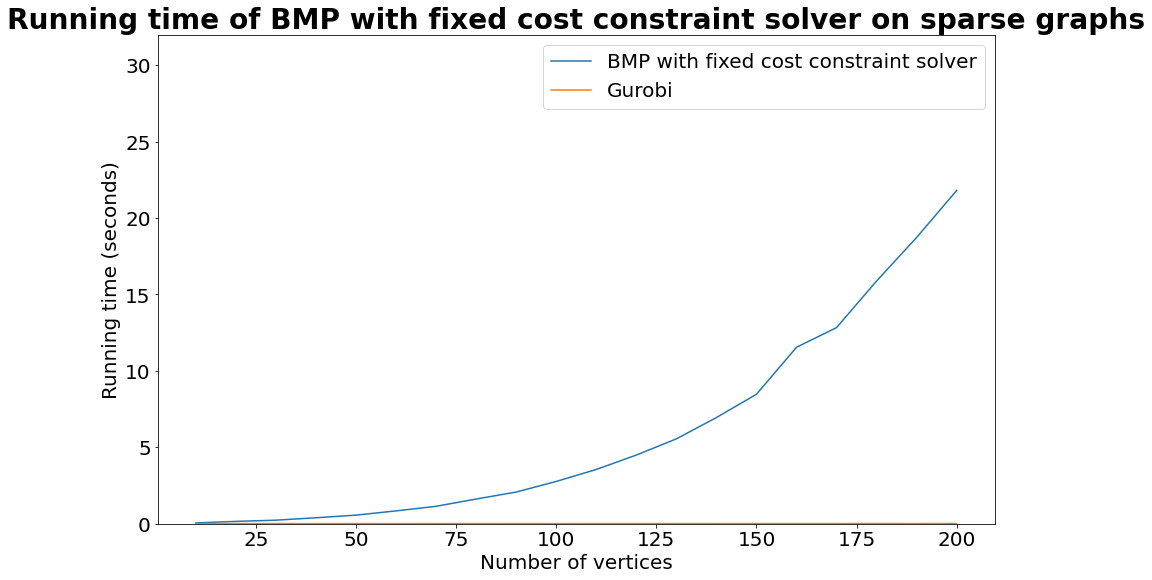

In [22]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['BMP with fixed cost constraint solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of BMP with fixed cost constraint solver on sparse graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim([0,32])
plt.show()